Edge length prediction.ipynb 
name of the notebook

# Dataset structure

In [ ]:
# google colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !pip install torch_geometric
# !pip install torch_sparse
# !pip install torch_scatter torchvision
!pip install yacs pytorch_lightning

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import itertools
import pickle
import numpy as np
import torch
from torch_geometric.data import data, Data
from torch_geometric.data import DataLoader
from torch_geometric.graphgym import GCNConv
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F
from tqdm import tqdm


/home/archie/.local/lib/python3.10/site-packages/torch_geometric/graphgym/imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [6]:
def load_pickle(file_name):
    f = open(file_name, "rb+")
    dataset = pickle.load(f)
    f.close()
    return dataset

def save_pickle(dataset, file_name):
    f = open(file_name, "wb")
    pickle.dump(dataset, f)
    f.close()

In [9]:
# import zipfile
# import pickle

# with zipfile.ZipFile('data/CSD_data_set_with_edge_type.pickle_2.zip', 'r') as zip_file:
#     pickle_file_name = zip_file.namelist()[0]

#     with zip_file.open(pickle_file_name, 'r') as pickle_file:
#         dataset = load_pickle(pickle_file)
#         # dataset = pickle.load(pickle_file)

# print(dataset)
import zipfile
import pickle

with zipfile.ZipFile('data/CSD_data_set_with_edge_type.pickle_2.zip', 'r') as zip_file:
    pickle_file_name = zip_file.namelist()[0]
    with zip_file.open(pickle_file_name, 'r') as pickle_file:
        dataset = pickle.load(pickle_file)

In [6]:
# from google.colab import files
# df = files.upload()
import zipfile
import pickle

with zipfile.ZipFile('data/CSD_data_set_with_edge_type.pickle_2.zip', 'r') as zip_file:
    pickle_file_name = zip_file.namelist()[0]

with zip_file.open(pickle_file_name, 'r') as pickle_file:
    dataset = load_pickle(pickle_file)
    # dataset = pickle.load(pickle_file)

print(dataset)

# datas = load_pickle('data/CSD_data_set_with_edge_type.pickle')
# datas = load_pickle('/content/drive/MyDrive/Workspace/network/CSD_data_set_with_edge_type.pickle_2/CSD_data_set_with_edge_type.pickle')

#The data is large and takes a long time to load

ValueError: Attempt to use ZIP archive that was already closed

In [ ]:
len(datas)
# Dataset size = 275711 graphs

In [ ]:
datas[10]
#Dataset structure, take the 10th Graph as an example

Data(x=[7, 30], edge_index=[2, 14], complete_edge_adj=[2, 42], complete_edge_len_tensors=[42], edge_len_tensors=[14], edge_types=[14, 11], atom_list=[7])

In [ ]:
datas[10].x
#The number of nodes in this Graph is 7, and the characteristic value of each node is 30

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=torch.float64)

In [ ]:
datas[10].edge_index
#The adjacency matrix of this Graph only considers the connection of real connected nodes

tensor([[0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6],
        [2, 3, 2, 5, 6, 0, 1, 0, 4, 3, 5, 1, 4, 1]])

In [ ]:
datas[10].complete_edge_adj
#The false adjacency matrix of this Graph, assuming that all nodes are connected

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6],
        [1, 2, 3, 4, 5, 6, 0, 2, 3, 4, 5, 6, 0, 1, 3, 4, 5, 6, 0, 1, 2, 4, 5, 6,
         0, 1, 2, 3, 5, 6, 0, 1, 2, 3, 4, 6, 0, 1, 2, 3, 4, 5]])

In [ ]:
datas[10].complete_edge_len_tensors

#The length of all sides (true side + false side) of this Graph
# is the target value that needs to be predicted after the task is improved and optimized

tensor([2.4338, 1.3271, 1.3185, 2.3969, 2.7643, 3.7974, 2.4338, 1.4086, 2.6969,
        2.3737, 1.3692, 1.5008, 1.3271, 1.4086, 2.2261, 2.6766, 2.3423, 2.5506,
        1.3185, 2.6969, 2.2261, 1.3733, 2.3225, 4.1968, 2.3969, 2.3737, 2.6766,
        1.3733, 1.3478, 3.7606, 2.7643, 1.3692, 2.3423, 2.3225, 1.3478, 2.5175,
        3.7974, 1.5008, 2.5506, 4.1968, 3.7606, 2.5175], dtype=torch.float64)

In [ ]:
datas[10].edge_len_tensors
#The length of all real edges of this Graph
# is the predicted target value of the graph neural network built by myself

tensor([1.3271, 1.3185, 1.4086, 1.3692, 1.5008, 1.3271, 1.4086, 1.3185, 1.3733,
        1.3733, 1.3478, 1.3692, 1.3478, 1.5008], dtype=torch.float64)

In [ ]:
datas[10].edge_types

#Edge features of the real edge of this Graph
# is the new information that needs to be added to the graph neural network after the task is improved and optimized
#The model I built before has not been added

tensor([[0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

## **Graph neural network model and training**

In [ ]:
def get_data():
    datas = load_pickle('data/CSD_data_set_with_edge_type.pickle')
    num_train = int(275711*0.06)
    num_val = int(275711*0.02)
    num_test = int(275711*0.02)
    batch_size = 10
    #
    train_and_val = [d.complete_edge_len_tensors.numpy().tolist() for d in datas[:num_train+num_val]]
    train_and_val = list(itertools.chain.from_iterable(train_and_val))
    # print(train_and_val)
    # normalization
    m, n = np.max(train_and_val), np.min(train_and_val)
    for idx, d in tqdm(enumerate(datas)):
        y = d.complete_edge_len_tensors.numpy()
        d.complete_edge_len_tensors = torch.FloatTensor((y - n) / (m - n))
        d = Data(x=d.x, edge_index=d.complete_edge_adj, edge_len_tensors=d.complete_edge_len_tensors,
                 pred_edge_len_tensors=d.complete_edge_len_tensors)
        datas[idx] = d

    train_loader = DataLoader(datas[:num_train], batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(datas[num_train:num_train+num_val], batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(datas[num_train+num_val:num_train+num_val+num_test], batch_size=batch_size, shuffle=True, drop_last=True)

    # save
    save_pickle(train_loader, 'loader/train.pkl')
    save_pickle(val_loader, 'loader/val.pkl')
    save_pickle(test_loader, 'loader/test.pkl')

    return train_loader, val_loader, test_loader, m, n

In [ ]:
import copy
import numpy as np
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool,GATConv
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(30, 32)
        self.conv2 = GCNConv(32, 64)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = x.float()
        # x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # x = global_mean_pool(x, batch)
        # 648 64
        # Calculate the distance according to the link
        x_src = x[edge_index[0]]
        x_dst = x[edge_index[1]]
        edge_x = torch.cat((x_src, x_dst), dim=1)
        out = self.fc(edge_x)
        out = torch.flatten(out)

        return out

In [ ]:


@torch.no_grad()
def test(model, val_loader, test_loader, m, n):
    model.eval()
    loss_function = torch.nn.MSELoss().to(device)
    val_losses = []
    for val in val_loader:
        val = val.to(device)
        out = model(val)
        loss = loss_function(out, val.edge_len_tensors.float())
        val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    # test
    y, pred = [], []
    for idx, te in enumerate(test_loader):
        te = te.to(device)
        out = model(te)
        # 反归一化  # Denormalize
        p = out.cpu().numpy()
        p = (m - n) * p + n
        # save pred
        te.pred_edge_len_tensors = torch.FloatTensor(p)
        test_loader[idx] = te
        y.extend(te.edge_len_tensors.cpu().numpy().tolist())
        pred.extend(out.cpu().numpy().tolist())

    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    mape = get_mape(y, pred)

    return val_loss, mape, test_loader


def train(train_loader, val_loader, test_loader, m, n):
    model = GCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
    loss_function = torch.nn.MSELoss().to(device)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    min_epochs = 5
    min_val_loss = 5
    best_model = []
    best_mape = 0
    model.train()
    for epoch in tqdm(range(10)):
        train_losses = []
        for tr in train_loader:
            tr = tr.to(device)
            out = model(tr)
            optimizer.zero_grad()
            loss = loss_function(out, tr.edge_len_tensors.float())
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.item())
        # validation
        val_loss, test_mape, test_loader = test(model, val_loader, test_loader, m, n)
        if val_loss < min_val_loss and epoch + 1 > min_epochs:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)
            best_mape = test_mape
        print('Epoch {:03d} train_loss {:.4f} val_loss {:.4f} test mape {:.4f}'.format(epoch,
                                                                                       np.mean(train_losses),
                                                                                       val_loss, test_mape))

    print('best mape:', best_mape)
    # Denormalize the ground truth
    for te in test_loader:
        t = te.edge_len_tensors.cpu().numpy()
        t = (m - n) * t + n
        te.edge_len_tensors = torch.FloatTensor(t)
        # Output the predicted value of the real value
        print(te.edge_len_tensors)
        print(te.pred_edge_len_tensors)
        print(len(te.edge_len_tensors) == len(te.pred_edge_len_tensors))
    return best_model
    

def get_mape(x, y):
    """
    :param x: true value
    :param y: pred value
    :return: mape
    """
    return np.mean(np.abs((x - y) / x))



In [ ]:

train_loader, val_loader, test_loader, m, n = get_data()
print(len(train_loader), len(val_loader), len(test_loader))
for x, y, z in zip(train_loader, val_loader, test_loader):
    print(x, y, z)
test_loader = [x for x in iter(test_loader)]

In [ ]:
model = train(train_loader, val_loader, test_loader, m, n)
torch.save(model.state_dict(), 'models/best_model')

 10%|█         | 1/10 [00:19<02:53, 19.27s/it]

Epoch 000 train_loss 5.9681 val_loss 0.7171 test mape 7.3247


 20%|██        | 2/10 [00:37<02:29, 18.74s/it]

Epoch 001 train_loss 0.6752 val_loss 0.7270 test mape 7.3247


 30%|███       | 3/10 [00:56<02:10, 18.67s/it]

Epoch 002 train_loss 0.6674 val_loss 0.7312 test mape 7.3247


 40%|████      | 4/10 [01:14<01:50, 18.41s/it]

Epoch 003 train_loss 0.6722 val_loss 0.7136 test mape 7.3247


 50%|█████     | 5/10 [01:32<01:31, 18.31s/it]

Epoch 004 train_loss 0.6751 val_loss 0.7244 test mape 7.3247


 60%|██████    | 6/10 [01:51<01:13, 18.45s/it]

Epoch 005 train_loss 0.6709 val_loss 0.7238 test mape 7.3247


 70%|███████   | 7/10 [02:09<00:55, 18.45s/it]

Epoch 006 train_loss 0.6755 val_loss 0.7243 test mape 7.3247


 80%|████████  | 8/10 [02:28<00:36, 18.47s/it]

Epoch 007 train_loss 0.6727 val_loss 0.7173 test mape 7.3247


 90%|█████████ | 9/10 [02:46<00:18, 18.34s/it]

Epoch 008 train_loss 0.6763 val_loss 0.7287 test mape 7.3247


100%|██████████| 10/10 [03:04<00:00, 18.42s/it]

Epoch 009 train_loss 0.6615 val_loss 0.7209 test mape 7.3247
best mape: 7.324737118744496
tensor([4.6965, 4.2055, 2.8386,  ..., 6.9244, 7.5832, 7.5133])
tensor([-34.5867, -34.5867, -34.5867,  ..., -37.0469, -37.0469, -37.0469])
True
tensor([3.4882, 4.0265, 5.3955,  ..., 2.7479, 2.3876, 1.3834])
tensor([-34.8784, -34.8785, -34.8785,  ..., -40.5714, -40.5714, -40.5714])
True
tensor([2.7277, 8.9075, 6.4560,  ..., 4.7488, 6.0997, 6.3723])
tensor([ 8.0211,  8.0211,  8.0211,  ..., -4.4907, -4.4907, -4.4907])
True
tensor([3.3765, 2.9289, 1.4233,  ..., 5.8673, 8.7950, 5.3786])
tensor([34.4550, 34.4550, 34.4550,  ..., 59.4158, 59.4158, 59.4158])
True
tensor([2.2598, 3.3699, 4.7729,  ..., 3.0692, 4.4277, 6.2308])
tensor([ 39.7282,  39.7282,  39.7282,  ..., -19.4246, -19.4246, -19.4246])
True
tensor([1.4350, 1.4378, 1.6465,  ..., 2.6983, 2.2716, 1.3779])
tensor([  2.3839,   2.3839,   2.3839,  ..., -56.4602, -56.4602, -56.4602])
True
tensor([1.5115, 2.5267, 3.8069,  ..., 2.7501, 2.3775, 1.3909])
t

## **Prediction result visualization**

In [ ]:
from torch_geometric.data import DataLoader
new_test_loader = DataLoader(datas[200000:], batch_size=1, shuffle=True, drop_last=True)

In [ ]:
for x in (new_test_loader):
    print(x)
new_test_loader = [x for x in iter(new_test_loader)]

In [ ]:
model = GCN().to(device)
model.load_state_dict(torch.load("models/best_model"))

<All keys matched successfully>

In [ ]:
model.state_dict()

In [ ]:
index = 120001
pred = model(datas[index])
pred = pred.detach().numpy()
pred = (m - n) * pred + n
print("pred:")
print(pred)
true = datas[index].edge_len_tensors
true = true.detach().numpy()
print("true:")
print(true)


pred:
[53.34795  55.615547 67.01299  55.615547 59.318913 69.21825  60.744102
 80.06297  64.040215 64.92157  79.35583  64.921524 77.64812  76.26142
 66.84211  66.842155 76.26142  77.64812  80.06297  60.744102 75.91642
 87.30393  55.615593 53.34786  55.615547 67.01304  59.318867 69.21825
 60.744102 80.063065 64.92157  64.04026  64.921616 79.35592  66.842064
 77.64807  76.26142  66.8422   76.26142  77.64812  60.744102 80.06297
 75.91651  87.30393 ]
true:
[1.50742056 1.50567412 1.42280664 1.51025033 1.50742056 1.51895698
 1.50567412 1.53472925 1.51895698 1.51923535 1.41316956 1.52370011
 1.53472925 1.53461481 1.52371593 1.51923535 1.53461481 1.53680188
 1.53680188 1.51025033 1.42280664 1.41316956 1.51025033 1.50742056
 1.50567412 1.42272021 1.50742056 1.51890699 1.50567412 1.53481509
 1.52371593 1.51890699 1.5192989  1.41322275 1.52370011 1.53481509
 1.53461025 1.5192989  1.53461025 1.53680188 1.51025033 1.53680188
 1.42272021 1.41322275]


In [ ]:
mape = get_mape(pred,true)
mape

0.977829950142691

In [ ]:
mapes = []
for i in range(len(new_test_loader)):
    pred = model(new_test_loader[i])
    pred = pred.detach().numpy()
    #print("pred:")
    #print(pred)
    true = new_test_loader[i].edge_len_tensors
    true = true.detach().numpy()
    #print("true:")
    #print(true)
    mape = get_mape(pred,true)
    #print(mape)
    mapes.append(mape)

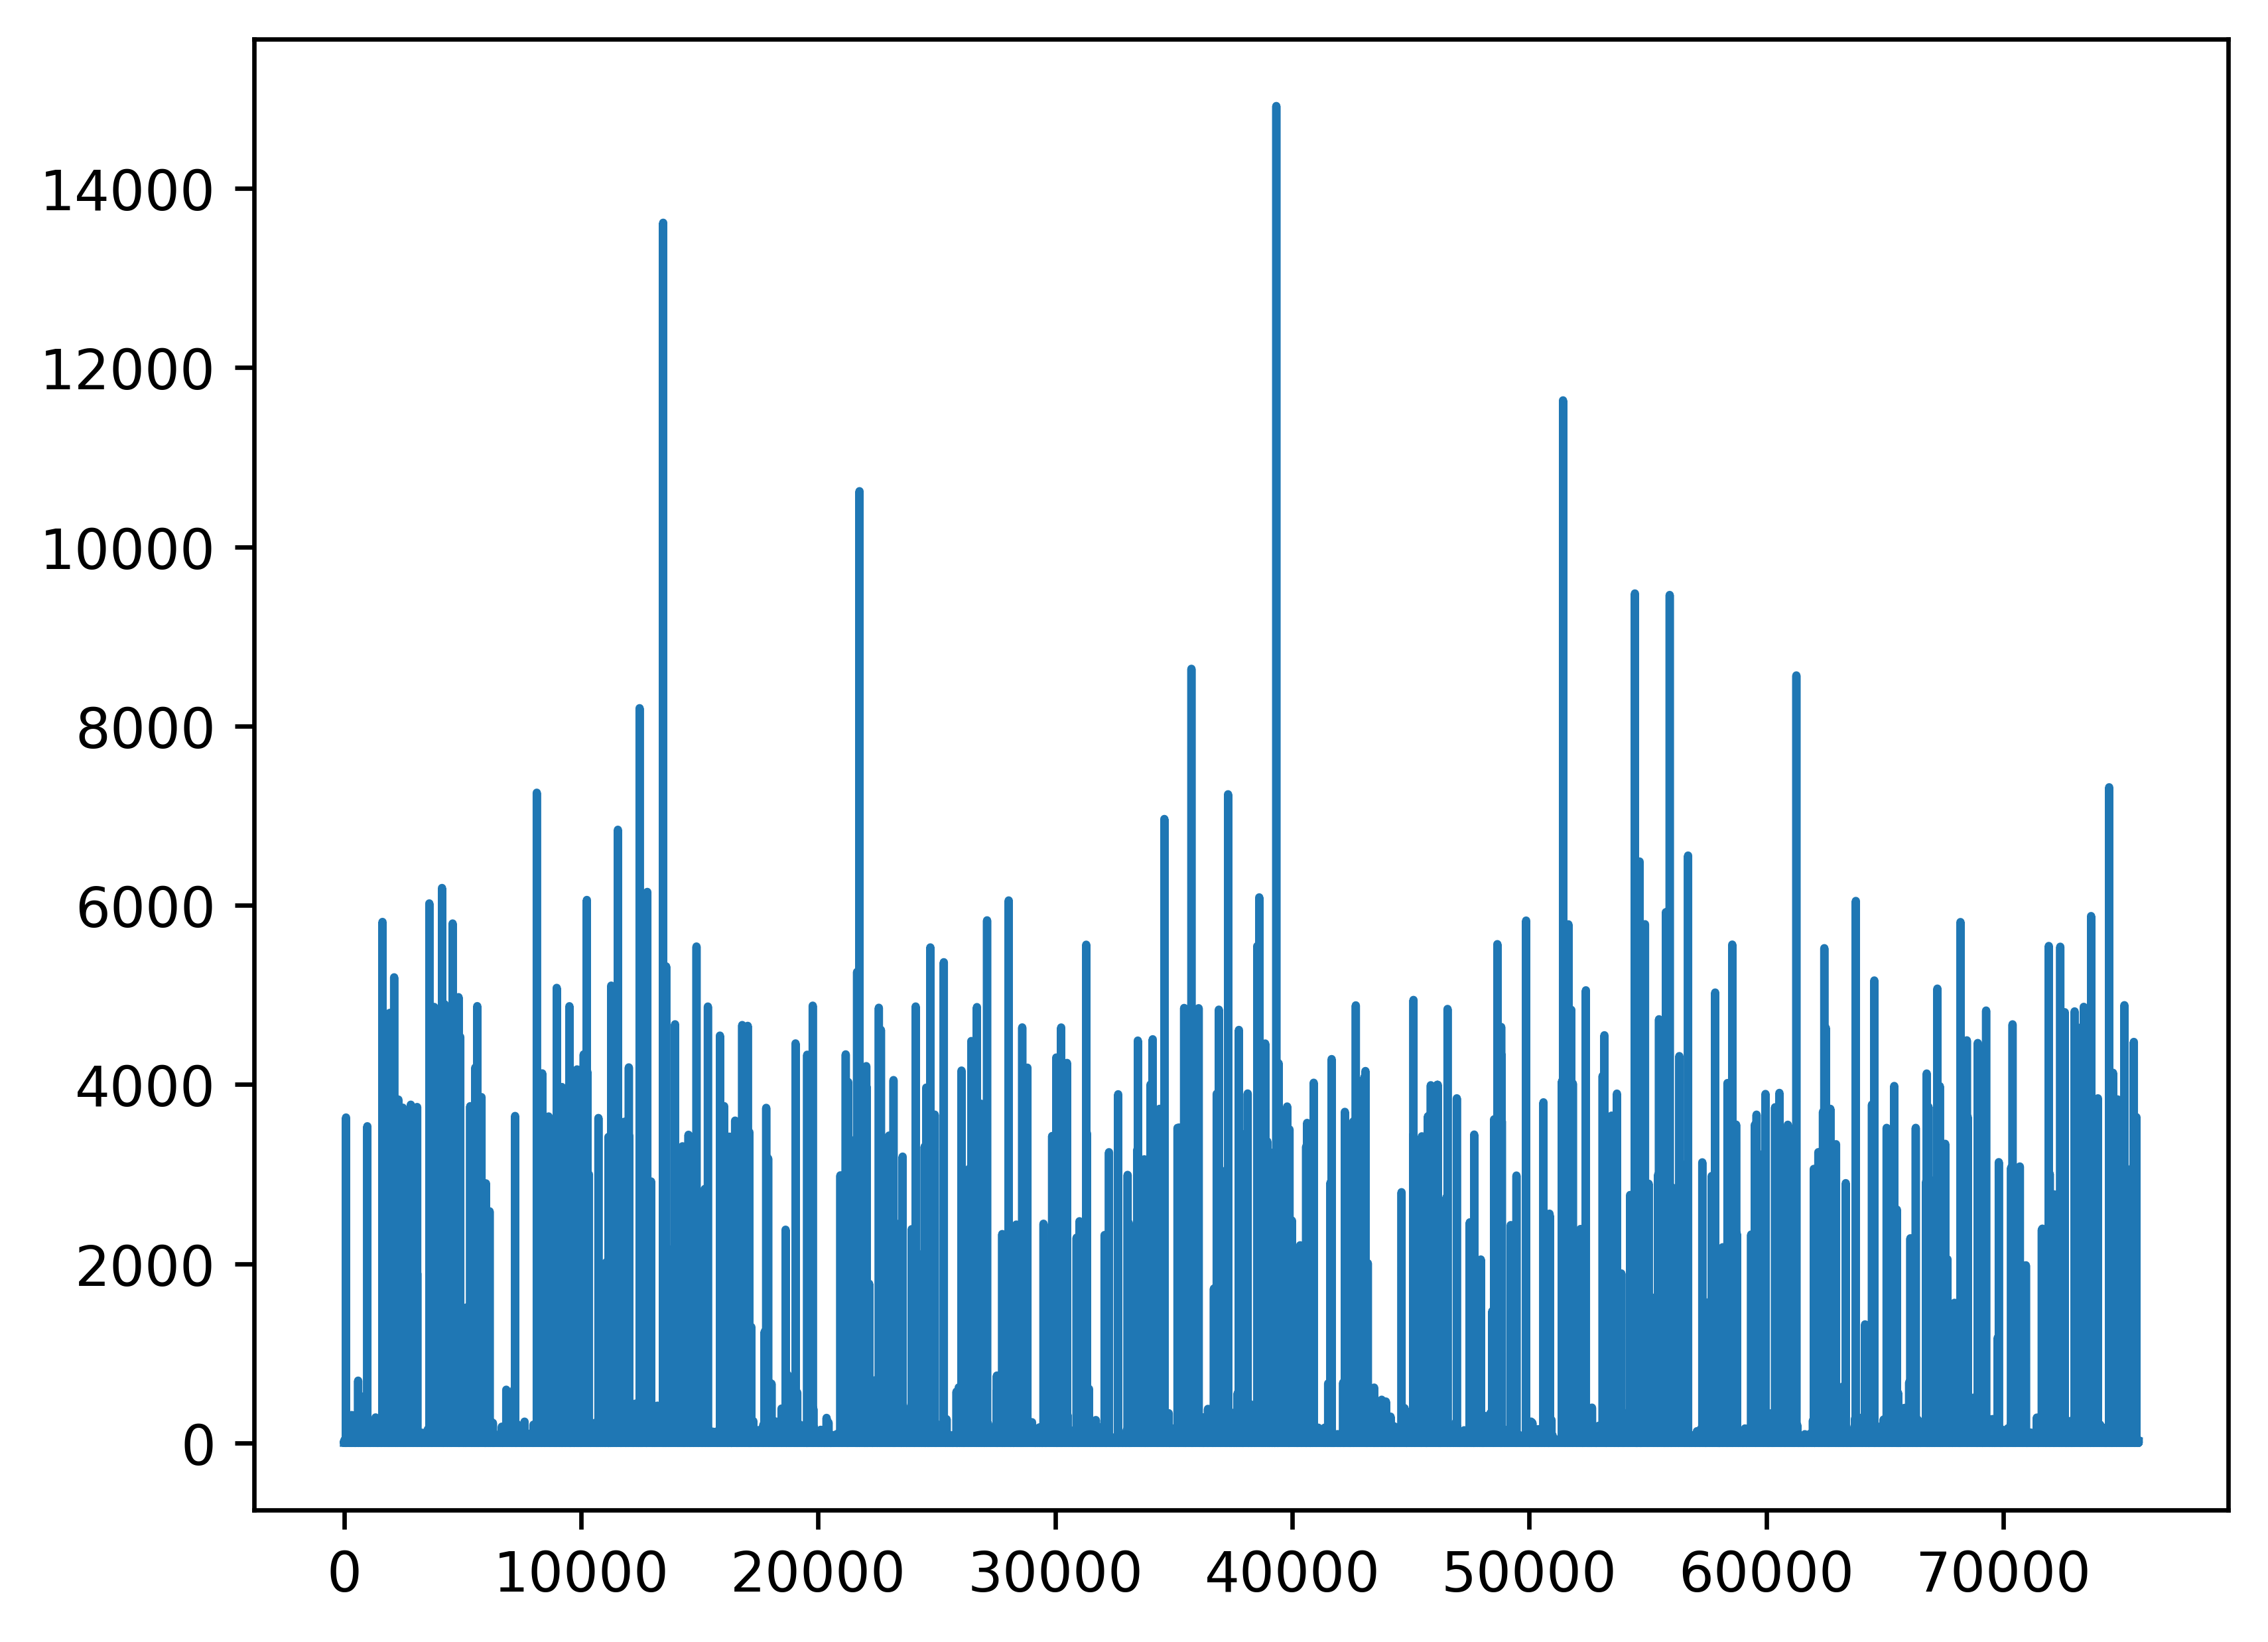

In [ ]:
import matplotlib.pyplot as plt

data = mapes
plt.plot(data)
plt.rcParams['figure.dpi']=600
plt.show()